# Third Assignment

##MSc course in Artificial Intelligence

Metehan Dündar

In [ ]:
# !rm -r AI_USI_MA/
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

In [ ]:
# Imports

from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic1 = TSP_Instance_Creator("standard", 'eil76.tsp')
ic1.print_info()
#ic1.plot_data()
print('\n--------------------------------------------------------------\n')
ic2 = TSP_Instance_Creator("standard", 'ch130.tsp')
ic2.print_info()
#ic2.plot_data()
print('\n--------------------------------------------------------------\n')
ic3 = TSP_Instance_Creator("standard", 'd198.tsp')
ic3.print_info()
#ic3.plot_data()

name: eil76
nPoints: 76
best_sol: 538.0

--------------------------------------------------------------

name: ch130
nPoints: 130
best_sol: 6110.0

--------------------------------------------------------------

name: d198
nPoints: 198
best_sol: 15780.0


In [ ]:
import numpy as np
from AI_USI_MA.solvers.local_search import twoOpt
from AI_USI_MA.solvers.constructive_algorithms import nn
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl
import time

# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1
  cl = 15 # or 20

  @staticmethod
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def take_remaining(self, j, dist_mat): # beyond candidate list
    return list(np.argsort(dist_mat[j])[ACS.cl:])

  def __init__(self, instance, q_0, seed, use_cl):
    self.ic = instance
    self.q_0 = q_0
    self.seed = seed
    self.use_cl = use_cl
    np.random.seed(seed)
    self.n = instance.nPoints
    self.dist_mat = instance.dist_matrix
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the Ants
    self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)}
    self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}

  def run(self):
    within_time_limit = True
    timeout = time.time() + 3*60
    tour_no = 0
    self.best_distance_list = [] # best tour distances for each round
    self.overall_best = 10000000 # checker for lower valued best tour
    self.len_to_plot = []

    while within_time_limit:
      if time.time() > timeout:
        break

      tour_no += 1
      self.available_positions = {i: [j for j in range(self.n)] for i in range(ACS.m)} # list of available cities left to traverse for each ant ({all cities}-tour_k)
      #initialising positions of the ants randomly at the start of the tour
      self.position = {i: np.random.randint(0, high=self.n) for i in range(ACS.m)}
      self.tour_distance = {i: 0.0 for i in range(ACS.m)}
      #reset tour
      self.tour = {i: [] for i in range(ACS.m)}


      for ant in range(len(self.available_positions)): # removing starting city of each ant from their list of available cities
        del(self.available_positions[ant][self.position[ant]])

      r_k = self.position.copy() # starting positions
      return_home = self.position.copy()

      for step in range(self.n):
        if step < self.n-1:
          # check for intersection between each ant's not-yet visited cities and the candidate list of current position
          overlap = {x: list(set(self.available_positions[x]) & set(self.candidate_list[self.position[x]])) for x in range(len(self.position))}
          # print(self.available_positions)
          # print(self.candidate_list)
          # print(overlap)
          # print('---------------')
          for ant in range(len(self.position)):
            # check there's 1 or more available cities which to exploit/explore for every ant
            if len(overlap[ant]) > 0:
              overlap_pheromone = []
              overlap_eta = []
              for overlap_city in overlap[ant]:
                candidate_idx = self.candidate_list[r_k[ant]].index(overlap_city)
                overlap_pheromone.append(self.pheromone[r_k[ant]][candidate_idx])
                overlap_eta.append(self.eta[r_k[ant]][candidate_idx])

              poss_transitions = overlap_pheromone*np.power(overlap_eta, ACS.beta)
              q = np.random.rand()

              # exploitation case
              if q <= self.q_0:
                s = max(poss_transitions)
                self.position[ant] = overlap[ant][np.where(poss_transitions == s)[0][0]]

              # exploration case
              else:
                summed_trans = sum(poss_transitions)
                # generates list of probabilities that sum to 1 be pseudo-randomly picked
                prob_array = [i / summed_trans for i in poss_transitions]
                n = len(poss_transitions)
                idx = np.random.choice(list(range(n)), p=prob_array)
                self.position[ant] = overlap[ant][idx]

              trans_idx = self.candidate_list[r_k[ant]].index(self.position[ant])
              #LOCAL transition rule
              self.pheromone[r_k[ant]][trans_idx] = (1 - ACS.rho) * self.pheromone[r_k[ant]][trans_idx] + ACS.rho * self.tau0

            else: # case of no overlap - find nearest unvisited city within available_positions
              next_best = self.take_remaining(r_k[ant], self.dist_mat)
              remaining_overlap = list(set(self.available_positions[ant]) & set(next_best))
              self.position[ant] = remaining_overlap[0]

            # updating s_k into each tour, creating tuple of (r_k,s_k)
            self.tour[ant].append((r_k[ant], self.position[ant]))

            # incrementing tour distance of each ant by distance traversed in transition
            self.tour_distance[ant] += self.dist_mat[r_k[ant], self.position[ant]]
            r_k[ant] = self.position[ant] # make s_k -> next r_k for following iter
            del_idx = self.available_positions[ant].index(self.position[ant])
            del(self.available_positions[ant][del_idx]) #remove visited city from available positions

        else: # ants travel back to first city
          for ant in range(ACS.m):
            self.tour[ant].append((r_k[ant], return_home[ant])) # final step of tour
            # incrementing tour distance of each ant by distance traversed in transition
            self.tour_distance[ant] += self.dist_mat[r_k[ant], return_home[ant]]

      # global best here, do for just best ant in the iteration
      best_tour_distance = min([self.tour_distance[i] for i in self.tour_distance])
      best_tour_idx = list(self.tour_distance.values()).index(best_tour_distance)

      # statistics
      self.best_tour_listed = [self.tour[best_tour_idx][i][0] for i in range(self.n)]
      self.best_tour_listed.append(self.tour[best_tour_idx][0][0]) #add the first city to the end of the list

      if self.use_cl:
        # 2-opt with CL
        self.tour, len_new = twoOpt_with_cl(self.best_tour_listed, best_tour_distance, self.dist_mat, self.candidate_list)
      else:
        # 2-opt without CL
        self.tour, len_new = twoOpt(self.best_tour_listed, best_tour_distance, self.dist_mat)

      if len_new < self.overall_best:
        self.tour_num_of_best = tour_no # to keep track of which tour number the new best is found at
        self.best_distance_list.append(len_new)
      else:
        self.best_distance_list.append(self.best_distance_list[-1]) # if no new best found this tour, best distance is same as last time
      self.len_to_plot.append(len_new)
      self.overall_best = min(self.best_distance_list)
      self.best_tour_listed.append(self.tour)
      print('___________________________________________________________________')
      print('Tour no: ', tour_no, ' length: ', len_new, ' with overall best: ', self.overall_best, ' achieved at iteration: ', self.tour_num_of_best)

      # global update
      for city in range(len(self.pheromone)):
        for connection in range(len(self.pheromone[city])):
          self.pheromone[city][connection] = (1 - ACS.alpha) * self.pheromone[city][connection]
          if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour
            self.pheromone[city][connection] += ACS.alpha * 1/best_tour_distance




# test twoOpt_with_cl

the implementation of 2opt with the candidate list has worst performances in term of quality but achieves improvements using fewer computation

In [ ]:
#2opt WITH Candidate Lists
eil76_05_0_cl = ACS(ic1, q_0=0.5, seed=0, use_cl=True)
eil76_05_1_cl = ACS(ic1, q_0=0.5, seed=1, use_cl=True)
eil76_05_2_cl = ACS(ic1, q_0=0.5, seed=2, use_cl=True)

eil76_098_0_cl = ACS(ic1, q_0=0.98, seed=0, use_cl=True)
eil76_098_1_cl = ACS(ic1, q_0=0.98, seed=1, use_cl=True)
eil76_098_2_cl = ACS(ic1, q_0=0.98, seed=2, use_cl=True)

eil76_13n_0_cl = ACS(ic1, q_0=1-13/ic1.nPoints, seed=0, use_cl=True)
eil76_13n_1_cl = ACS(ic1, q_0=1-13/ic1.nPoints, seed=1, use_cl=True)
eil76_13n_2_cl = ACS(ic1, q_0=1-13/ic1.nPoints, seed=2, use_cl=True)

ch130_05_0_cl = ACS(ic2, q_0=0.5, seed=0, use_cl=True)
ch130_05_1_cl = ACS(ic2, q_0=0.5, seed=1, use_cl=True)
ch130_05_2_cl = ACS(ic2, q_0=0.5, seed=2, use_cl=True)

ch130_098_0_cl = ACS(ic2, q_0=0.98, seed=0, use_cl=True)
ch130_098_1_cl = ACS(ic2, q_0=0.98, seed=1, use_cl=True)
ch130_098_2_cl = ACS(ic2, q_0=0.98, seed=2, use_cl=True)

ch130_13n_0_cl = ACS(ic2, q_0=1-13/ic2.nPoints, seed=0, use_cl=True)
ch130_13n_1_cl = ACS(ic2, q_0=1-13/ic2.nPoints, seed=1, use_cl=True)
ch130_13n_2_cl = ACS(ic2, q_0=1-13/ic2.nPoints, seed=2, use_cl=True)

d198_05_0_cl = ACS(ic3, q_0=0.5, seed=0, use_cl=True)
d198_05_1_cl = ACS(ic3, q_0=0.5, seed=1, use_cl=True)
d198_05_2_cl = ACS(ic3, q_0=0.5, seed=2, use_cl=True)

d198_098_0_cl = ACS(ic3, q_0=0.98, seed=0, use_cl=True)
d198_098_1_cl = ACS(ic3, q_0=0.98, seed=1, use_cl=True)
d198_098_2_cl = ACS(ic3, q_0=0.98, seed=2, use_cl=True)

d198_13n_0_cl = ACS(ic3, q_0=1-13/ic3.nPoints, seed=0, use_cl=True)
d198_13n_1_cl = ACS(ic3, q_0=1-13/ic3.nPoints, seed=1, use_cl=True)
d198_13n_2_cl = ACS(ic3, q_0=1-13/ic3.nPoints, seed=2, use_cl=True)

In [ ]:
eil76_05_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  591.0  with overall best:  591.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  601.0  with overall best:  591.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  605.0  with overall best:  591.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  593.0  with overall best:  591.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  556.0  with overall best:  556.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  584.0  with overall best:  556.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  609.0  with overall best:  556.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  8  length:  598.0  with overall best:  556.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  9  length:  585.0  wit

In [ ]:
eil76_05_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  583.0  with overall best:  583.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  590.0  with overall best:  583.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  595.0  with overall best:  583.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  572.0  with overall best:  572.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  612.0  with overall best:  572.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  614.0  with overall best:  572.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  612.0  with overall best:  572.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:  593.0  with overall best:  572.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  9  length:  628.0  wit

In [ ]:
eil76_05_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  582.0  with overall best:  582.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  582.0  with overall best:  582.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  578.0  with overall best:  578.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  573.0  with overall best:  573.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  580.0  with overall best:  573.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  599.0  with overall best:  573.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  591.0  with overall best:  573.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:  591.0  with overall best:  573.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  9  length:  619.0  wit

In [ ]:
eil76_098_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  615.0  with overall best:  615.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  561.0  with overall best:  561.0  achieved at iteration:  2


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  572.0  with overall best:  561.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  579.0  with overall best:  561.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  565.0  with overall best:  561.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  573.0  with overall best:  561.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  564.0  with overall best:  561.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  8  length:  593.0  with overall best:  561.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  9  length:  578.0  wit

In [ ]:
eil76_098_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  615.0  with overall best:  615.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  571.0  with overall best:  571.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  624.0  with overall best:  571.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  593.0  with overall best:  571.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  596.0  with overall best:  571.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  583.0  with overall best:  571.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  602.0  with overall best:  571.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  8  length:  586.0  wit

In [ ]:
eil76_098_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  572.0  with overall best:  572.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  562.0  with overall best:  562.0  achieved at iteration:  2


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  560.0  with overall best:  560.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  576.0  with overall best:  560.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  588.0  with overall best:  560.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  573.0  with overall best:  560.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  560.0  with overall best:  560.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  8  length:  576.0  with overall best:  560.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  9  length:  567.0  wit

In [ ]:
eil76_13n_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  601.0  with overall best:  601.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  603.0  with overall best:  601.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  570.0  with overall best:  570.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  581.0  with overall best:  570.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  589.0  with overall best:  570.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  587.0  with overall best:  570.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  566.0  with overall best:  566.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:  616.0  wit

In [ ]:
eil76_13n_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  593.0  with overall best:  593.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  584.0  with overall best:  584.0  achieved at iteration:  2


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  589.0  with overall best:  584.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  566.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  592.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  580.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  580.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:  596.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  9  length:  584.0  wit

In [ ]:
eil76_13n_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  581.0  with overall best:  581.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  610.0  with overall best:  581.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  580.0  with overall best:  580.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  575.0  with overall best:  575.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  592.0  with overall best:  575.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  620.0  with overall best:  575.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  590.0  with overall best:  575.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:  598.0  wit

In [ ]:
ch130_05_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  7094.0  with overall best:  7094.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  7209.0  with overall best:  7094.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6927.0  with overall best:  6927.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  7013.0  with overall best:  6927.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  7235.0  with overall best:  6927.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  6901.0  with overall best:  6901.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  6998.0  with overall best:  6901.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_05_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  7015.0  with overall best:  7015.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  7179.0  with overall best:  7015.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6899.0  with overall best:  6899.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  7422.0  with overall best:  6899.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  6740.0  with overall best:  6740.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  6971.0  with overall best:  6740.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  6657.0  with overall best:  6657.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_05_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  7005.0  with overall best:  7005.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6719.0  with overall best:  6719.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  7399.0  with overall best:  6719.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  6897.0  with overall best:  6719.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  7187.0  with overall best:  6719.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  7112.0  with overall best:  6719.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  7361.0  with overall best:  6719.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_098_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  7092.0  with overall best:  7092.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  7045.0  with overall best:  7045.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  7009.0  with overall best:  7009.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  6822.0  with overall best:  6822.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  6592.0  with overall best:  6592.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  6500.0  with overall best:  6500.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  6558.0  with overall best:  6500.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_098_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  7045.0  with overall best:  7045.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6885.0  with overall best:  6885.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6992.0  with overall best:  6885.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  7085.0  with overall best:  6885.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  6891.0  with overall best:  6885.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  6821.0  with overall best:  6821.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  6614.0  with overall best:  6614.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_098_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  6800.0  with overall best:  6800.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6727.0  with overall best:  6727.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6553.0  with overall best:  6553.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  7224.0  with overall best:  6553.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  6750.0  with overall best:  6553.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  7069.0  with overall best:  6553.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  7013.0  with overall best:  6553.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_13n_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  6691.0  with overall best:  6691.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  7192.0  with overall best:  6691.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6854.0  with overall best:  6691.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  7155.0  with overall best:  6691.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  7080.0  with overall best:  6691.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  6881.0  with overall best:  6691.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  6768.0  with overall best:  6691.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_13n_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  7009.0  with overall best:  7009.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  7169.0  with overall best:  7009.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6810.0  with overall best:  6810.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  7058.0  with overall best:  6810.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  6858.0  with overall best:  6810.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  6990.0  with overall best:  6810.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  7142.0  with overall best:  6810.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_13n_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  6623.0  with overall best:  6623.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6688.0  with overall best:  6623.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  7310.0  with overall best:  6623.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  7203.0  with overall best:  6623.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  6640.0  with overall best:  6623.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  7209.0  with overall best:  6623.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  6900.0  with overall best:  6623.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  8  length:

In [ ]:
d198_05_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  17968.0  with overall best:  17968.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  18427.0  with overall best:  17968.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  17588.0  with overall best:  17588.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  17504.0  with overall best:  17504.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  17441.0  with overall best:  17441.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  17932.0  with overall best:  17441.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  17881.0  with overall best:  17441.0  achieved at iteration:  5
___________________________________________________________________
Tour no:

In [ ]:
d198_05_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  18685.0  with overall best:  18685.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  17841.0  with overall best:  17841.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  18795.0  with overall best:  17841.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  17947.0  with overall best:  17841.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  17970.0  with overall best:  17841.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  19418.0  with overall best:  17841.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  18202.0  with overall best:  17841.0  achieved at iteration:  2
___________________________________________________________________
Tour no:

In [ ]:
d198_05_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  18955.0  with overall best:  18955.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  19933.0  with overall best:  18955.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  17930.0  with overall best:  17930.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  18361.0  with overall best:  17930.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  18582.0  with overall best:  17930.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  17393.0  with overall best:  17393.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  17835.0  with overall best:  17393.0  achieved at iteration:  6
___________________________________________________________________
Tour no:

In [ ]:
d198_098_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  17402.0  with overall best:  17402.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16550.0  with overall best:  16550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  17520.0  with overall best:  16550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  17345.0  with overall best:  16550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  17219.0  with overall best:  16550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  17260.0  with overall best:  16550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  17526.0  with overall best:  16550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:

In [ ]:
d198_098_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  17054.0  with overall best:  17054.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  17197.0  with overall best:  17054.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  17301.0  with overall best:  17054.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  17443.0  with overall best:  17054.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  17928.0  with overall best:  17054.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  17342.0  with overall best:  17054.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  17086.0  with overall best:  17054.0  achieved at iteration:  1
___________________________________________________________________
Tour no:

In [ ]:
d198_098_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  17607.0  with overall best:  17607.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  17427.0  with overall best:  17427.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  17664.0  with overall best:  17427.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  17499.0  with overall best:  17427.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  17674.0  with overall best:  17427.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  17278.0  with overall best:  17278.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  17248.0  with overall best:  17248.0  achieved at iteration:  7
___________________________________________________________________
Tour no:

In [ ]:
d198_13n_0_cl.run()

___________________________________________________________________
Tour no:  1  length:  19351.0  with overall best:  19351.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16676.0  with overall best:  16676.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  16906.0  with overall best:  16676.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  17313.0  with overall best:  16676.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  17553.0  with overall best:  16676.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  16535.0  with overall best:  16535.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  18484.0  with overall best:  16535.0  achieved at iteration:  6
___________________________________________________________________
Tour no:

In [ ]:
d198_13n_1_cl.run()

___________________________________________________________________
Tour no:  1  length:  17317.0  with overall best:  17317.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  17187.0  with overall best:  17187.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  17638.0  with overall best:  17187.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  16937.0  with overall best:  16937.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  17610.0  with overall best:  16937.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  17634.0  with overall best:  16937.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  17112.0  with overall best:  16937.0  achieved at iteration:  4
___________________________________________________________________
Tour no:

In [ ]:
d198_13n_2_cl.run()

___________________________________________________________________
Tour no:  1  length:  17516.0  with overall best:  17516.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  17358.0  with overall best:  17358.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  17181.0  with overall best:  17181.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  17894.0  with overall best:  17181.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  18463.0  with overall best:  17181.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  17440.0  with overall best:  17181.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  16945.0  with overall best:  16945.0  achieved at iteration:  7
___________________________________________________________________
Tour no:

In [ ]:
#2opt WITHOUT Candidate Lists
eil76_05_0 = ACS(ic1, q_0=0.5, seed=0, use_cl=False)
eil76_05_1 = ACS(ic1, q_0=0.5, seed=1, use_cl=False)
eil76_05_2 = ACS(ic1, q_0=0.5, seed=2, use_cl=False)

eil76_098_0 = ACS(ic1, q_0=0.98, seed=0, use_cl=False)
eil76_098_1 = ACS(ic1, q_0=0.98, seed=1, use_cl=False)
eil76_098_2 = ACS(ic1, q_0=0.98, seed=2, use_cl=False)

eil76_13n_0 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=0, use_cl=False)
eil76_13n_1 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=1, use_cl=False)
eil76_13n_2 = ACS(ic1, q_0=1-13/ic1.nPoints, seed=2, use_cl=False)

ch130_05_0 = ACS(ic2, q_0=0.5, seed=0, use_cl=False)
ch130_05_1 = ACS(ic2, q_0=0.5, seed=1, use_cl=False)
ch130_05_2 = ACS(ic2, q_0=0.5, seed=2, use_cl=False)

ch130_098_0 = ACS(ic2, q_0=0.98, seed=0, use_cl=False)
ch130_098_1 = ACS(ic2, q_0=0.98, seed=1, use_cl=False)
ch130_098_2 = ACS(ic2, q_0=0.98, seed=2, use_cl=False)

ch130_13n_0 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=0, use_cl=False)
ch130_13n_1 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=1, use_cl=False)
ch130_13n_2 = ACS(ic2, q_0=1-13/ic2.nPoints, seed=2, use_cl=False)

d198_05_0 = ACS(ic3, q_0=0.5, seed=0, use_cl=False)
d198_05_1 = ACS(ic3, q_0=0.5, seed=1, use_cl=False)
d198_05_2 = ACS(ic3, q_0=0.5, seed=2, use_cl=False)

d198_098_0 = ACS(ic3, q_0=0.98, seed=0, use_cl=False)
d198_098_1 = ACS(ic3, q_0=0.98, seed=1, use_cl=False)
d198_098_2 = ACS(ic3, q_0=0.98, seed=2, use_cl=False)

d198_13n_0 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=0, use_cl=False)
d198_13n_1 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=1, use_cl=False)
d198_13n_2 = ACS(ic3, q_0=1-13/ic3.nPoints, seed=2, use_cl=False)

In [ ]:
eil76_05_0.run()

___________________________________________________________________
Tour no:  1  length:  557.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  578.0  with overall best:  557.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  3  length:  561.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  581.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  581.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  582.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  560.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  8  length:  561.0  with overall best:  557.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  9  length:  567.0  wit

In [ ]:
eil76_05_1.run()

___________________________________________________________________
Tour no:  1  length:  548.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  588.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  581.0  with overall best:  548.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  589.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  574.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  606.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  586.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  8  length:  599.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  9  length:  591.0  with overall best:  548.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  10  length:  579.0  wi

In [ ]:
eil76_05_2.run()

___________________________________________________________________
Tour no:  1  length:  571.0  with overall best:  571.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  575.0  with overall best:  571.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  555.0  with overall best:  555.0  achieved at iteration:  3


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  570.0  with overall best:  555.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  563.0  with overall best:  555.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  581.0  with overall best:  555.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  578.0  with overall best:  555.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  8  length:  580.0  with overall best:  555.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  9  length:  600.0  with overall best:  555.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  10  length:  565.0  wi

In [ ]:
eil76_098_0.run()

___________________________________________________________________
Tour no:  1  length:  562.0  with overall best:  562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  567.0  with overall best:  562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  562.0  with overall best:  562.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  575.0  with overall best:  562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  575.0  with overall best:  562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  578.0  with overall best:  562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  554.0  with overall best:  554.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:  572.0  with overall best:  554.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  9  length:  570.0  with overall best:  554.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  10  length:  570.0  wi

In [ ]:
eil76_098_1.run()

___________________________________________________________________
Tour no:  1  length:  559.0  with overall best:  559.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  598.0  with overall best:  559.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  576.0  with overall best:  559.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  569.0  with overall best:  559.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  567.0  with overall best:  559.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  550.0  with overall best:  550.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  558.0  with overall best:  550.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  8  length:  549.0  with overall best:  549.0  achieved at iteration:  8
___________________________________________________________________
Tour no:  9  length:  547.0  with overall best:  547.0  achieved at iteration:  9
___________________________________________________________________
Tour no:  10  length:  565.0  wi

In [ ]:
eil76_098_2.run()

___________________________________________________________________
Tour no:  1  length:  560.0  with overall best:  560.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  578.0  with overall best:  560.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  566.0  with overall best:  560.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  555.0  with overall best:  555.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  574.0  with overall best:  555.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  571.0  with overall best:  555.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  588.0  with overall best:  555.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:  557.0  with overall best:  555.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  9  length:  560.0  with overall best:  555.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  10  length:  569.0  wi

In [ ]:
eil76_13n_0.run()

___________________________________________________________________
Tour no:  1  length:  574.0  with overall best:  574.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  567.0  with overall best:  567.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  569.0  with overall best:  567.0  achieved at iteration:  2


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  587.0  with overall best:  567.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  572.0  with overall best:  567.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  591.0  with overall best:  567.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  562.0  with overall best:  562.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:  571.0  with overall best:  562.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  9  length:  578.0  with overall best:  562.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  10  length:  559.0  wi

In [ ]:
eil76_13n_1.run()

___________________________________________________________________
Tour no:  1  length:  571.0  with overall best:  571.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  586.0  with overall best:  571.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  594.0  with overall best:  571.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  583.0  with overall best:  571.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  568.0  with overall best:  568.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  576.0  with overall best:  568.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  557.0  with overall best:  557.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:  575.0  with overall best:  557.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  9  length:  566.0  with overall best:  557.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  10  length:  572.0  wi

In [ ]:
eil76_13n_2.run()

___________________________________________________________________
Tour no:  1  length:  568.0  with overall best:  568.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  2  length:  571.0  with overall best:  568.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  579.0  with overall best:  568.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  4  length:  566.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  569.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  595.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  574.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:  583.0  with overall best:  566.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  9  length:  560.0  with overall best:  560.0  achieved at iteration:  9
___________________________________________________________________
Tour no:  10  length:  579.0  wi

In [ ]:
ch130_05_0.run()

___________________________________________________________________
Tour no:  1  length:  6554.0  with overall best:  6554.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6831.0  with overall best:  6554.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6720.0  with overall best:  6554.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  6382.0  with overall best:  6382.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  6887.0  with overall best:  6382.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  6421.0  with overall best:  6382.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  6487.0  with overall best:  6382.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_05_1.run()

___________________________________________________________________
Tour no:  1  length:  6622.0  with overall best:  6622.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6503.0  with overall best:  6503.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6702.0  with overall best:  6503.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  6405.0  with overall best:  6405.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  6505.0  with overall best:  6405.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  6784.0  with overall best:  6405.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  6424.0  with overall best:  6405.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_05_2.run()

___________________________________________________________________
Tour no:  1  length:  6736.0  with overall best:  6736.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6674.0  with overall best:  6674.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6279.0  with overall best:  6279.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  6478.0  with overall best:  6279.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  6362.0  with overall best:  6279.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  6455.0  with overall best:  6279.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  6527.0  with overall best:  6279.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_098_0.run()

___________________________________________________________________
Tour no:  1  length:  6562.0  with overall best:  6562.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6667.0  with overall best:  6562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6600.0  with overall best:  6562.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  6383.0  with overall best:  6383.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  6328.0  with overall best:  6328.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  6432.0  with overall best:  6328.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  6733.0  with overall best:  6328.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_098_1.run()

___________________________________________________________________
Tour no:  1  length:  6455.0  with overall best:  6455.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6560.0  with overall best:  6455.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  6473.0  with overall best:  6455.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  6632.0  with overall best:  6455.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  6385.0  with overall best:  6385.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  6722.0  with overall best:  6385.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  6347.0  with overall best:  6347.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_098_2.run()

___________________________________________________________________
Tour no:  1  length:  6464.0  with overall best:  6464.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6366.0  with overall best:  6366.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6664.0  with overall best:  6366.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  6643.0  with overall best:  6366.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  6505.0  with overall best:  6366.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  6584.0  with overall best:  6366.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  6337.0  with overall best:  6337.0  achieved at iteration:  7
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_13n_0.run()

___________________________________________________________________
Tour no:  1  length:  6605.0  with overall best:  6605.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6550.0  with overall best:  6550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6894.0  with overall best:  6550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  6557.0  with overall best:  6550.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  6412.0  with overall best:  6412.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  6446.0  with overall best:  6412.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  6699.0  with overall best:  6412.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_13n_1.run()

___________________________________________________________________
Tour no:  1  length:  6819.0  with overall best:  6819.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6392.0  with overall best:  6392.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6646.0  with overall best:  6392.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  6470.0  with overall best:  6392.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  6891.0  with overall best:  6392.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  6932.0  with overall best:  6392.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  6433.0  with overall best:  6392.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  8  length:

In [ ]:
ch130_13n_2.run()

___________________________________________________________________
Tour no:  1  length:  6685.0  with overall best:  6685.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  6369.0  with overall best:  6369.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  6651.0  with overall best:  6369.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  6518.0  with overall best:  6369.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  6467.0  with overall best:  6369.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  6385.0  with overall best:  6369.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  6588.0  with overall best:  6369.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  8  length:

In [ ]:
d198_05_0.run()

___________________________________________________________________
Tour no:  1  length:  16596.0  with overall best:  16596.0  achieved at iteration:  1


<ipython-input-5-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16601.0  with overall best:  16596.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  16421.0  with overall best:  16421.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  16743.0  with overall best:  16421.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  5  length:  16926.0  with overall best:  16421.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  6  length:  16861.0  with overall best:  16421.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  7  length:  16543.0  with overall best:  16421.0  achieved at iteration:  3
___________________________________________________________________
Tour no:

In [ ]:
d198_05_1.run()

___________________________________________________________________
Tour no:  1  length:  16742.0  with overall best:  16742.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16046.0  with overall best:  16046.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  16479.0  with overall best:  16046.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  16506.0  with overall best:  16046.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  16459.0  with overall best:  16046.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  16938.0  with overall best:  16046.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  16344.0  with overall best:  16046.0  achieved at iteration:  2
___________________________________________________________________
Tour no:

In [ ]:
d198_05_2.run()

___________________________________________________________________
Tour no:  1  length:  16563.0  with overall best:  16563.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16544.0  with overall best:  16544.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  16431.0  with overall best:  16431.0  achieved at iteration:  3
___________________________________________________________________
Tour no:  4  length:  16361.0  with overall best:  16361.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  16640.0  with overall best:  16361.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  6  length:  16610.0  with overall best:  16361.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  7  length:  16526.0  with overall best:  16361.0  achieved at iteration:  4
___________________________________________________________________
Tour no:

In [ ]:
d198_098_0.run()

___________________________________________________________________
Tour no:  1  length:  16343.0  with overall best:  16343.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16645.0  with overall best:  16343.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  16424.0  with overall best:  16343.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  16438.0  with overall best:  16343.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  16540.0  with overall best:  16343.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  16213.0  with overall best:  16213.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  16481.0  with overall best:  16213.0  achieved at iteration:  6
___________________________________________________________________
Tour no:

In [ ]:
d198_098_1.run()

___________________________________________________________________
Tour no:  1  length:  16251.0  with overall best:  16251.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16366.0  with overall best:  16251.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  17234.0  with overall best:  16251.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  16721.0  with overall best:  16251.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  16491.0  with overall best:  16251.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  16145.0  with overall best:  16145.0  achieved at iteration:  6
___________________________________________________________________
Tour no:  7  length:  16394.0  with overall best:  16145.0  achieved at iteration:  6
___________________________________________________________________
Tour no:

In [ ]:
d198_098_2.run()

___________________________________________________________________
Tour no:  1  length:  16514.0  with overall best:  16514.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16255.0  with overall best:  16255.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  16487.0  with overall best:  16255.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  16302.0  with overall best:  16255.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  16286.0  with overall best:  16255.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  16492.0  with overall best:  16255.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  16253.0  with overall best:  16253.0  achieved at iteration:  7
___________________________________________________________________
Tour no:

In [ ]:
d198_13n_0.run()

___________________________________________________________________
Tour no:  1  length:  16312.0  with overall best:  16312.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16437.0  with overall best:  16312.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  16967.0  with overall best:  16312.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  16240.0  with overall best:  16240.0  achieved at iteration:  4
___________________________________________________________________
Tour no:  5  length:  16137.0  with overall best:  16137.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  6  length:  16364.0  with overall best:  16137.0  achieved at iteration:  5
___________________________________________________________________
Tour no:  7  length:  16444.0  with overall best:  16137.0  achieved at iteration:  5
___________________________________________________________________
Tour no:

In [ ]:
d198_13n_1.run()

___________________________________________________________________
Tour no:  1  length:  16272.0  with overall best:  16272.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16207.0  with overall best:  16207.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  3  length:  16433.0  with overall best:  16207.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  4  length:  16317.0  with overall best:  16207.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  5  length:  17049.0  with overall best:  16207.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  6  length:  16400.0  with overall best:  16207.0  achieved at iteration:  2
___________________________________________________________________
Tour no:  7  length:  16527.0  with overall best:  16207.0  achieved at iteration:  2
___________________________________________________________________
Tour no:

In [ ]:
d198_13n_2.run()

___________________________________________________________________
Tour no:  1  length:  16029.0  with overall best:  16029.0  achieved at iteration:  1


<ipython-input-8-e79c4f9c6bbc>:158: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ((city, connection) in self.tour): #changed from 'in self.tour[best_tour_idx] for 2opt as only returns one tour


___________________________________________________________________
Tour no:  2  length:  16668.0  with overall best:  16029.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  3  length:  16334.0  with overall best:  16029.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  4  length:  16720.0  with overall best:  16029.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  5  length:  16312.0  with overall best:  16029.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  6  length:  16480.0  with overall best:  16029.0  achieved at iteration:  1
___________________________________________________________________
Tour no:  7  length:  16294.0  with overall best:  16029.0  achieved at iteration:  1
___________________________________________________________________
Tour no:

# **The best gap and cost achieved, and the number of tours generated to achieve the best tour.**

2-Opt with CL
---
1.   eil76 (optimal solution: 538), 3-minute run ≈ 700 tours
  *   Seed: 0, q0 = 0.5: Best Tour Length 547 (gap=9, cost=0.01673), found at tour number 388
  *   Seed: 1, q0 = 0.5: Best Tour Length 549 (gap=11, cost=0.02045), found at tour number 891
  *   Seed: 2, q0 = 0.5: Best Tour Length 550 (gap=12, cost=0.02230), found at tour number 39
  ---
  *   Seed: 0, q0 = 0.98: Best Tour Length 546 (gap=8, cost=0.01487), found at tour number 431
  *   Seed: 1, q0 = 0.98: Best Tour Length 545 (gap=7, cost=0.01301), found at tour number 403
  *   Seed: 2, q0 = 0.98: Best Tour Length 544 (gap=6, cost=0.01115), found at tour number 266
  ---
  *   Seed: 0, q0 =  1 − 13/n: Best Tour Length 545 (gap=7, cost=0.01301), found at tour number 250
  *   Seed: 1, q0 =  1 − 13/n: Best Tour Length 542 (gap=4, cost=0.00744), found at tour number 415
  *   **Seed: 2, q0 =  1 − 13/n: Best Tour Length 541 (gap=3, cost=0.00558), found at tour number 222**

2.   ch130 (optimal solution: 6110), 3-minute run ≈ 370 tours
  *   Seed: 0, q0 = 0.5: Best Tour Length 6304 (gap=194, cost=0.03175), found at tour number 264
  *   Seed: 1, q0 = 0.5: Best Tour Length 6324 (gap=214, cost=0.03502), found at tour number 136
  *   Seed: 2, q0 = 0.5: Best Tour Length 6393 (gap=283, cost=0.04632), found at tour number 64
  ---
  *   Seed: 0, q0 = 0.98: Best Tour Length 6371 (gap=261, cost=0.04272), found at tour number 445
  *   Seed: 1, q0 = 0.98: Best Tour Length 6395 (gap=285, cost=0.04664), found at tour number 9
  *   Seed: 2, q0 = 0.98: Best Tour Length 6300 (gap=190, cost=0.03110), found at tour number 56
  ---
  *   **Seed: 0, q0 =  1 − 13/n: Best Tour Length 6278 (gap=168, cost=0.02750), found at tour number 280**
  *   Seed: 1, q0 =  1 − 13/n: Best Tour Length 6310 (gap=200, cost=0.03273), found at tour number 319
  *   Seed: 2, q0 =  1 − 13/n: Best Tour Length 6337 (gap=227, cost=0.03715), found at tour number 78

3.   d198 (optimal solution: 15780), 3-minute run ≈ 220 tours
  *   Seed: 0, q0 = 0.5: Best Tour Length 16668 (gap=888, cost=0.05627), found at tour number 261
  *   **Seed: 1, q0 = 0.5: Best Tour Length 16166 (gap=386, cost=0.02446), found at tour number 135**
  *   Seed: 2, q0 = 0.5: Best Tour Length 16457 (gap=677, cost=0.04290), found at tour number 39
  ---
  *   Seed: 0, q0 = 0.98: Best Tour Length 16330 (gap=550, cost=0.03485), found at tour number 110
  *   Seed: 1, q0 = 0.98: Best Tour Length 16618 (gap=838, cost=0.05311), found at tour number 14
  *   Seed: 2, q0 = 0.98: Best Tour Length 16785 (gap=1005, cost=0.06369), found at tour number 9
  ---
  *   Seed: 0, q0 =  1 − 13/n: Best Tour Length 16535 (gap=755, cost=0.04785), found at tour number 6
  *   Seed: 1, q0 =  1 − 13/n: Best Tour Length 16467 (gap=687, cost=0.04354), found at tour number 238
  *   Seed: 2, q0 =  1 − 13/n: Best Tour Length 16380 (gap=600, cost=0.03802), found at tour number 12

2-Opt without CL
---
1.   eil76 (optimal solution: 538), 3 minute run ≈ 700 tours
  *   **Seed: 0, q0 = 0.5: Best Tour Length 538 (gap=0, cost=0), found at tour number 710**
  *   Seed: 1, q0 = 0.5: Best Tour Length 542 (gap=4, cost=0.00744), found at tour number 1728
  *   Seed: 2, q0 = 0.5: Best Tour Length 540 (gap=2, cost=0.00372), found at tour number 960
  ---
  *   Seed: 0, q0 = 0.98: Best Tour Length 539 (gap=1, cost=0.00186), found at tour number 1032
  *   Seed: 1, q0 = 0.98: Best Tour Length 543 (gap=5, cost=0.00929), found at tour number 1708
  *   Seed: 2, q0 = 0.98: Best Tour Length 540 (gap=2, cost= 0.00372), found at tour number 1750
  ---
  *   Seed: 0, q0 =  1 − 13/n: Best Tour Length 539 (gap=1, cost=0.00186), found at tour number 252
  *   Seed: 1, q0 =  1 − 13/n: Best Tour Length 538 (gap=0, cost=0), found at tour number 1000
  *   Seed: 2, q0 =  1 − 13/n: Best Tour Length 544 (gap=6, cost=0.01115), found at tour number 547

2.   ch130 (optimal solution: 6110), 3 minute run ≈ 370 tours
  *   Seed: 0, q0 = 0.5: Best Tour Length 6234 (gap=124, cost=0.02029), found at tour number 105
  *   Seed: 1, q0 = 0.5: Best Tour Length 6252 (gap=142, cost=0.02324), found at tour number 534
  *   **Seed: 2, q0 = 0.5: Best Tour Length 6165 (gap=55, cost=0.00900), found at tour number 69**
  ---
  *   Seed: 0, q0 = 0.98: Best Tour Length 6172 (gap=62, cost=0.01015), found at tour number 633
  *   Seed: 1, q0 = 0.98: Best Tour Length 6168 (gap=58, cost=0.00949), found at tour number 702
  *   Seed: 2, q0 = 0.98: Best Tour Length 6180 (gap=70, cost=0.01146), found at tour number 16
  ---
  *   Seed: 0, q0 =  1 − 13/n: Best Tour Length 6211 (gap=101, cost=0.01653), found at tour number 77
  *   Seed: 1, q0 =  1 − 13/n: Best Tour Length 6189 (gap=79, cost=0.01293), found at tour number 430
  *   Seed: 2, q0 =  1 − 13/n: Best Tour Length 6181 (gap=71, cost=0.01162), found at tour number 313

3.   d198 (optimal solution: 15780), 3 minute run ≈ 220 tours
  *   Seed: 0, q0 = 0.5: Best Tour Length 16102 (gap=322, cost=0.02041), found at tour number 74
  *   Seed: 1, q0 = 0.5: Best Tour Length 16043 (gap=263, cost=0.01667), found at tour number 62
  *   Seed: 2, q0 = 0.5: Best Tour Length 16074 (gap=294, cost=0.01863), found at tour number 135
  ---
  *   Seed: 0, q0 = 0.98: Best Tour Length 16082 (gap=302, cost=0.01914), found at tour number 178
  *   Seed: 1, q0 = 0.98: Best Tour Length 16141 (gap=361, cost=0.02288), found at tour number 102
  *   Seed: 2, q0 = 0.98: Best Tour Length 16007 (gap=227, cost=0.01439), found at tour number 179
  ---
  *   Seed: 0, q0 =  1 − 13/n: Best Tour Length 16065 (gap=285, cost=0.01806), found at tour number 50
  *   **Seed: 1, q0 =  1 − 13/n: Best Tour Length 15940 (gap=160, cost=0.01014), found at tour number 96**
  *   Seed: 2, q0 =  1 − 13/n: Best Tour Length 15972 (gap=192, cost=0.01217), found at tour number 96




# **A table mirroring the results of the integer length of the shortest tour found, the number of tours required to find it, the average integer length, the standard deviation, the optimal solution and the relative error of ACS**

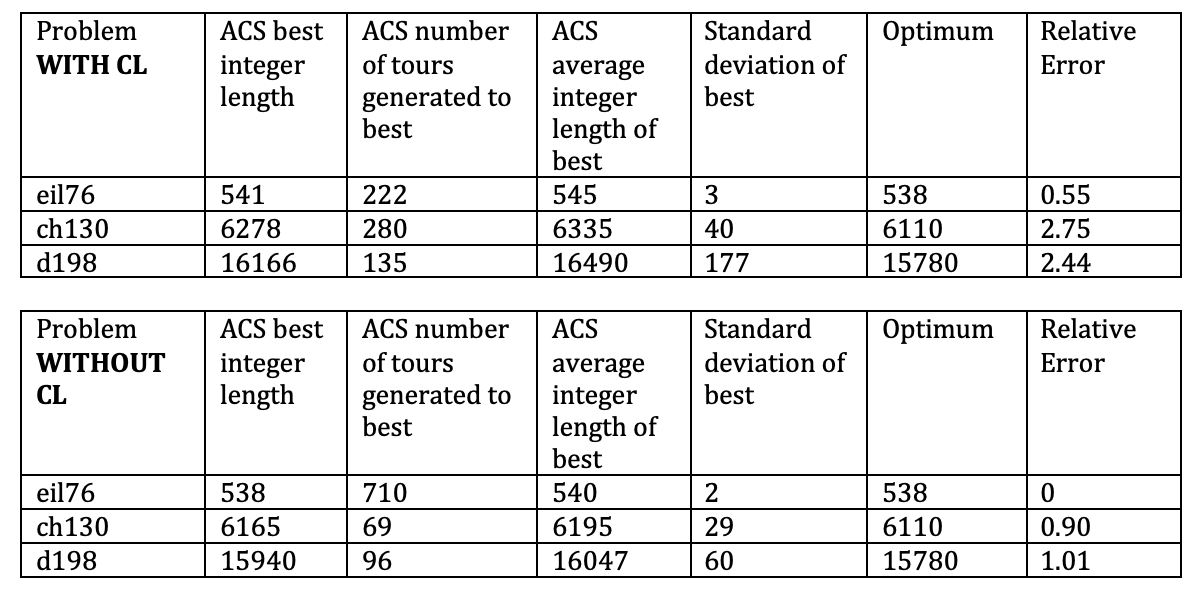

In [ ]:
import matplotlib.pyplot as plt

#mean values across iterations WITHOUT CL
avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# eil76 stats
for i in range(len(eil76_05_2.best_distance_list)):
  avg05.append(eil76_05_0.best_distance_list[i]/3 + eil76_05_1.best_distance_list[i]/3 + eil76_05_2.best_distance_list[i]/3)
  avg098.append(eil76_098_0.best_distance_list[i]/3 + eil76_098_1.best_distance_list[i]/3 + eil76_098_2.best_distance_list[i]/3)
  avg13n.append(eil76_13n_0.best_distance_list[i]/3 + eil76_13n_1.best_distance_list[i]/3 + eil76_13n_2.best_distance_list[i]/3)
for i in range(len(eil76_05_2.best_distance_list)) :
  overall_avg.append((avg05[i]/3 - 538)+ (avg098[i]/3 - 538)+ (avg13n[i]/3 - 538))
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('eil76 average without Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# ch130 stats
for i in range(len(ch130_05_2.best_distance_list)):
  avg05.append(ch130_05_0.best_distance_list[i]/3 + ch130_05_1.best_distance_list[i]/3 + ch130_05_2.best_distance_list[i]/3)
  avg098.append(ch130_098_0.best_distance_list[i]/3 + ch130_098_1.best_distance_list[i]/3 + ch130_098_2.best_distance_list[i]/3)
  avg13n.append(ch130_13n_0.best_distance_list[i]/3 + ch130_13n_1.best_distance_list[i]/3 + ch130_13n_2.best_distance_list[i]/3)

for i in range(len(ch130_05_2.best_distance_list)) :
  overall_avg.append((avg05[i]/3 - 6110) + (avg098[i]/3 - 6110) + (avg13n[i]/3 - 6110))
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('ch130 average without Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# d198 stats
for i in range(len(d198_05_0.best_distance_list)):
  avg05.append(d198_05_0.best_distance_list[i]/3 + d198_05_1.best_distance_list[i]/3 + d198_05_2.best_distance_list[i]/3)
  avg098.append(d198_098_0.best_distance_list[i]/3 + d198_098_1.best_distance_list[i]/3 + d198_098_2.best_distance_list[i]/3)
  avg13n.append(d198_13n_0.best_distance_list[i]/3 + d198_13n_1.best_distance_list[i]/3 + d198_13n_2.best_distance_list[i]/3)

for i in range(len(d198_05_0.best_distance_list)) :
  overall_avg.append((avg05[i]/3 - 15780) + (avg098[i]/3 - 15780)+ (avg13n[i]/3 - 15780))
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('d198 average without Candidate List')
plt.legend()
plt.show()

In [ ]:
#mean values across iterations WITH CL

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# eil76 stats
for i in range(len(eil76_098_0_cl.best_distance_list)):
  avg05.append(eil76_05_0_cl.best_distance_list[i]/3 + eil76_05_1_cl.best_distance_list[i]/3 + eil76_05_2_cl.best_distance_list[i]/3)
  avg098.append(eil76_098_0_cl.best_distance_list[i]/3 + eil76_098_1_cl.best_distance_list[i]/3 + eil76_098_2_cl.best_distance_list[i]/3)
  avg13n.append(eil76_13n_0_cl.best_distance_list[i]/3 + eil76_13n_1_cl.best_distance_list[i]/3 + eil76_13n_2_cl.best_distance_list[i]/3)
for i in range(len(eil76_098_0_cl.best_distance_list)) :
  overall_avg.append((avg05[i]/3 - 538) + (avg098[i]/3 - 538) + (avg13n[i]/3 - 538))
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('eil76 average with Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# ch130 stats
for i in range(len(ch130_05_2_cl.best_distance_list)):
  avg05.append(ch130_05_0_cl.best_distance_list[i]/3 + ch130_05_1_cl.best_distance_list[i]/3 + ch130_05_2_cl.best_distance_list[i]/3)
  avg098.append(ch130_098_0_cl.best_distance_list[i]/3 + ch130_098_1_cl.best_distance_list[i]/3 + ch130_098_2_cl.best_distance_list[i]/3)
  avg13n.append(ch130_13n_0_cl.best_distance_list[i]/3 + ch130_13n_1_cl.best_distance_list[i]/3 + ch130_13n_2_cl.best_distance_list[i]/3)

for i in range(len(ch130_05_2_cl.best_distance_list)) :
  overall_avg.append((avg05[i]/3 - 6110) + (avg098[i]/3 - 6110) + (avg13n[i]/3 - 6110))
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('ch130 average with Candidate List')
plt.legend()
plt.show()

avg05 = []
avg098 = []
avg13n = []
overall_avg = []

# d198 stats
for i in range(len(d198_098_2_cl.best_distance_list)):
  avg05.append(d198_05_0_cl.best_distance_list[i]/3 + d198_05_1_cl.best_distance_list[i]/3 + d198_05_2_cl.best_distance_list[i]/3)
  avg098.append(d198_098_0_cl.best_distance_list[i]/3 + d198_098_1_cl.best_distance_list[i]/3 + d198_098_2_cl.best_distance_list[i]/3)
  avg13n.append(d198_13n_0_cl.best_distance_list[i]/3 + d198_13n_1_cl.best_distance_list[i]/3 + d198_13n_2_cl.best_distance_list[i]/3)

for i in range(len(d198_098_2_cl.best_distance_list)):
  overall_avg.append((avg05[i]/3 - 15780) + (avg098[i]/3 - 15780) + (avg13n[i]/3 - 15780))
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(range(len(overall_avg)), overall_avg, label='overallavg')
plt.title('d198 average with Candidate List')
plt.legend()
plt.show()

# **!! The provided codes effectively generate plots for the values; however, due to Google Colab crashing before completion of all runs, resulting in a runtime of 3 hours for all test cases, there is a loss of local variables. Consequently, it becomes impractical to plot all values simultaneously.**

# **Comments on the results**

* **Exploration vs. Exploitation:** The results highlight the delicate balance between exploration and exploitation in solving TSP instances. Adjusting the exploration probability (q0) based on problem size and instance characteristics proves crucial for achieving optimal or near-optimal solutions.

* **2-Opt with Candidate Lists vs. without Candidate Lists:** The presence of candidate lists seems to influence the algorithm's behavior. Without candidate lists, the algorithm demonstrates efficient exploration, consistently achieving optimal or near-optimal solutions. However, the performance may vary based on the problem.